# Read Original Data

In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

mpl.rcParams['figure.dpi']= 150

In [2]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT.values
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


In [3]:
# You only need to run this once
gbm = xgb.XGBRegressor(learning_rate=0.01,  
                       objective='reg:squarederror', 
                       n_estimators=2000, 
                       reg_alpha=1,
                       reg_lambda=10,
                       max_depth=10, 
                       gamma=0.1)
gbm.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1, reg_lambda=10, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [4]:
def baseline_model():
    # create model
    # Sequential model is for just building up each layer
    model = Sequential()
    # Kernel initializer sets up the distribution for the random parameters
    model.add(Dense(50, 
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, 
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


model = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=50, verbose=0)
model.fit(X, Y)

# Read and Plot Interpolated Data

In [4]:
# Read all data and merge
thick_con_interpolated = []
for i in range(0,49):
    temp_df = pd.read_csv('Mult'+str(i))
    # print(i, temp_df.iloc[:,2].values)
    thick_con_interpolated.append(temp_df.iloc[:,2].values)

In [5]:
# Transpose to match the format
thick_con_interpolated = np.transpose(np.array(thick_con_interpolated))

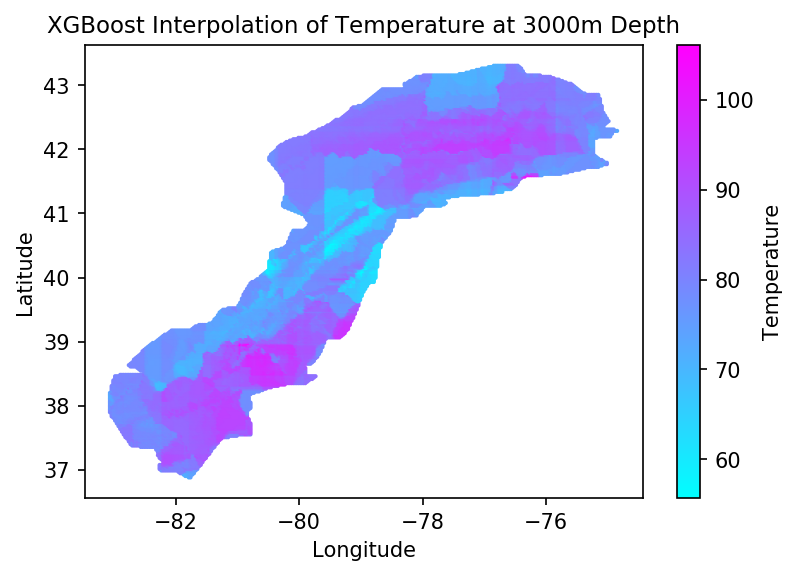

In [7]:
z_guess = 3000 # Give your z, 500~3000
df_interpolated = pd.DataFrame({'lat':temp_df.iloc[:,1].values,'lon':temp_df.iloc[:,0].values,
                                'z':np.full((len(temp_df.iloc[:,0].values),),z_guess),
                                't_surf':pd.read_csv('T_surf_knn').iloc[:,2].values}) # z is all z guess
X_interpolated = np.concatenate((df_interpolated.values,thick_con_interpolated),axis=1)
X_interpolated.shape
# Run the training code above first.
xgb_pred = gbm.predict(X_interpolated)
#dnn_pred = model.predict(X_interpolated)


#Visalization
plt.scatter(df_interpolated.lon, df_interpolated.lat,
            c=xgb_pred, cmap='cool',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('XGBoost Interpolation of Temperature at '+str(z_guess)+'m Depth', fontsize=11)
#plt.clim(290-273,380-273)
#plt.colorbar().set_clim(290,380)
plt.colorbar().set_label('Temperature')
plt.show()

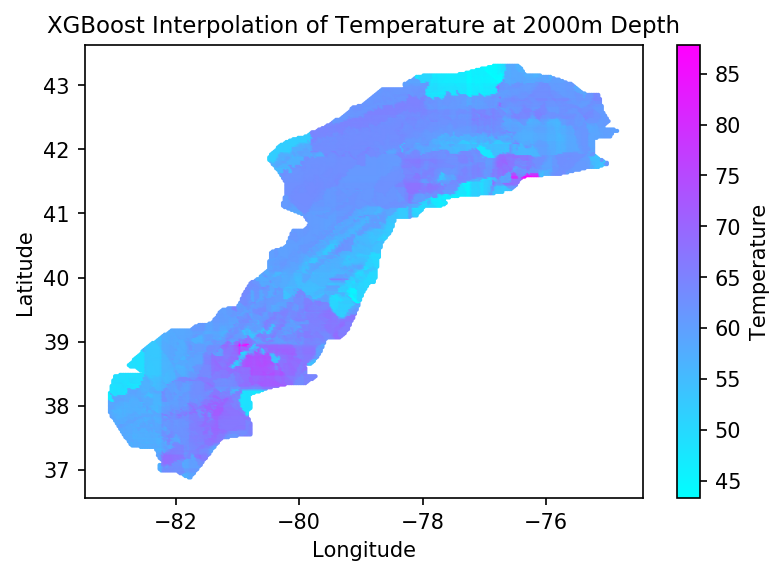

In [8]:
z_guess = 2000 # Give your z, 500~3000
df_interpolated = pd.DataFrame({'lat':temp_df.iloc[:,1].values,'lon':temp_df.iloc[:,0].values,
                                'z':np.full((len(temp_df.iloc[:,0].values),),z_guess),
                                't_surf':pd.read_csv('T_surf_knn').iloc[:,2].values}) # z is all z guess
X_interpolated = np.concatenate((df_interpolated.values,thick_con_interpolated),axis=1)
X_interpolated.shape
# Run the training code above first.
xgb_pred = gbm.predict(X_interpolated)
#dnn_pred = model.predict(X_interpolated)


#Visalization
plt.scatter(df_interpolated.lon, df_interpolated.lat,
            c=xgb_pred, cmap='cool',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('XGBoost Interpolation of Temperature at '+str(z_guess)+'m Depth', fontsize=11)
#plt.clim(290-273,380-273)
#plt.colorbar().set_clim(290,380)
plt.colorbar().set_label('Temperature')
plt.show()

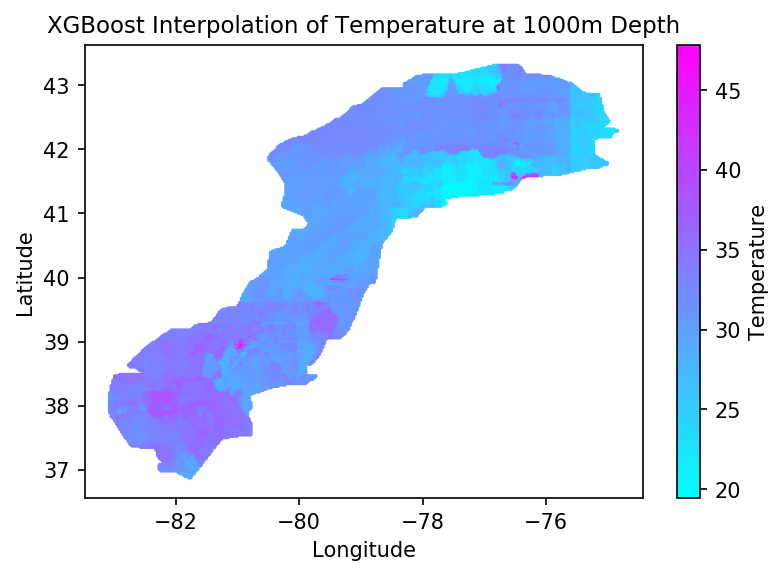

In [9]:
z_guess = 1000 # Give your z, 500~3000
df_interpolated = pd.DataFrame({'lat':temp_df.iloc[:,1].values,'lon':temp_df.iloc[:,0].values,
                                'z':np.full((len(temp_df.iloc[:,0].values),),z_guess),
                                't_surf':pd.read_csv('T_surf_knn').iloc[:,2].values}) # z is all z guess
X_interpolated = np.concatenate((df_interpolated.values,thick_con_interpolated),axis=1)
X_interpolated.shape
# Run the training code above first.
xgb_pred = gbm.predict(X_interpolated)
#dnn_pred = model.predict(X_interpolated)


#Visalization
plt.scatter(df_interpolated.lon, df_interpolated.lat,
            c=xgb_pred, cmap='cool',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('XGBoost Interpolation of Temperature at '+str(z_guess)+'m Depth', fontsize=11)
#plt.clim(290-273,380-273)
#plt.colorbar().set_clim(290,380)
plt.colorbar().set_label('Temperature')
plt.show()

In [24]:
# retrieval of the coloarbar range by showing minimum and maximum
print(min(xgb_pred), max(xgb_pred))

55.67907 106.08338


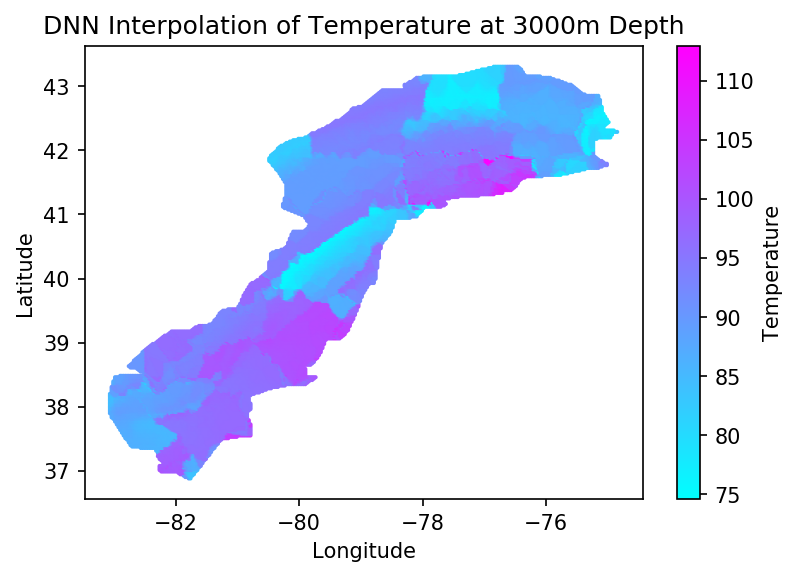

In [69]:
plt.scatter(df_interpolated.lon, df_interpolated.lat,
            c=dnn_pred, cmap='cool',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DNN Interpolation of Temperature at '+str(z_guess)+'m Depth',)
#plt.clim(290-273,380-273)
#plt.colorbar().set_clim(290,380)
plt.colorbar().set_label('Temperature')
plt.show()